# Биоразнообразие vs DHI: разведочный анализ-3

Цель документа -- визуализировать зависимости между биоразнообразием и DHI, найти типичные шаблоны в пространственном размещении.

Это документ продолжение [первой части](https://176.9.38.120/cruncher/notebooks/DHI/DHI_biodiversity.ipynb), в которой анализировался файл, содержащий DHI, рассчитанный по "сырым" данным fpar, а также [второй части, где анализируются данные, содержащие DHI, рассчитанные по сглаженным данным](https://176.9.38.120/cruncher/notebooks/DHI/DHI_biodiversity_Phase2.ipynb). В этом документе в таблицу добавлена информация по антропогенному воздействию.

## Беглый взгляд на данные

Данные хранятся в файле `DATA/wwf_globe_all_biomes_filtered_dhi_hfp.csv`, прочитаем его:

In [1]:
points = read.table('DATA/wwf_globe_all_biomes_filtered_dhi_hfp.csv', header = TRUE, sep=",")

### Описательная статистика:

Получим краткую сводку по содержанию столбцов (минимум, 1-й квартиль, медиана, среднее, 3-й квартиль и максимум):

In [2]:
summary(points)

       X                 Y                CID          AMPHIBIANS   
 Min.   :-179.87   Min.   :-55.255   Min.   :    1   Min.   :  0.0  
 1st Qu.: -62.71   1st Qu.:  1.047   1st Qu.: 7517   1st Qu.:  2.0  
 Median :  33.62   Median : 39.007   Median :15030   Median :  6.0  
 Mean   :  22.99   Mean   : 29.114   Mean   :15010   Mean   : 13.1  
 3rd Qu.: 100.18   3rd Qu.: 56.833   3rd Qu.:22527   3rd Qu.: 16.0  
 Max.   : 179.63   Max.   : 79.990   Max.   :30000   Max.   :131.0  
                                                                    
   BIRDS_glob      MAMMTERR_g       REPTILES_g        avg_dhi_1     
 Min.   :  3.0   Min.   :  0.00   Min.   :  0.000   Min.   :   0.0  
 1st Qu.:128.0   1st Qu.: 30.00   1st Qu.:  1.000   1st Qu.: 907.9  
 Median :188.0   Median : 45.00   Median :  5.000   Median :1584.6  
 Mean   :209.8   Mean   : 57.96   Mean   :  9.884   Mean   :1795.3  
 3rd Qu.:272.0   3rd Qu.: 68.00   3rd Qu.: 14.000   3rd Qu.:2472.3  
 Max.   :611.0   Max.   :200.00   

### Описание столбцов с данными.

**Общая информация:**

Каждая строка таблицы (запись) представляет собой одну точку на поверхности Земли в которой были замеряны определенные параметры. Всего имеется 30 тысяч точек.

 * CID: Идентификатор записи.
 * X: Долгота.
 * Y: Широта.
 
**Биоразнообразие:**

 * AMPHIBIANS: Показатель, характеризующий биоразнообразие амфибий.
 * BIRDS_glob: Показатель, характеризующий биоразнообразие птиц.
 * MAMMTERR_g: Показатель, характеризующий биоразнообразие наземных млекопитающих.
 * REPTILES_g: Показатель, характеризующий биоразнообразие рептилий.

 
**Показатели продуктивности:**

Данные DHI -- специальные индексы, основанные на показателе продуктивности FPAR (Fraction of Absorbed Photosynthetically Active radiation) -- это доля солнечного излучения, поглощенного растительной биомассой, измеряется в процентах. Индексы `avg*` - рассчитаны по сглаженным рядам FPAR.

 * avg_dhi_1: DHI для FPAR. Куммулятивная продуктивность: рассчитывается суммированием FPAR за год (интеграл).
 * avg_dhi_2: DHI для FPAR. Минимальная продуктивность: минимальное значение FPAR за год.
 * avg_dhi3: DHI для FPAR. Сезонность: расчитывается как отношение стандартного отклонения FPAR к его среднему значению (за год). Таким образом большая величина dhi_fpar3 означает большое колебание продутивности в течении года.
 
**Антропогенное воздействие**
 * humanFP: антропогенное воздействие, рассчитано каким-то волшебным образом из плотности населения, дорожной сети и др. Нужно разобраться подробнее.
 
*Примечание 1.* Отсутсвующие данные из предыдущего файла по биоразнообразию уже отфильтрованы.
 
*Примечание 2.* Отсутвтующие данные для DHI из предыдущего файла уже отфильтрованы.

На графике видно, что в среднем куммулятивная и минимальная продуктивности в новых данных выше, а сезонность ниже. При этом часть новых данных сбросилась в ноль. Этот ноль объясняется тем, что DHI точек, попадающих в пустыни, воду, города и т.п. был насильственно сброшен до нулевого состояния (ранее они могли быть выше нуля из-за атмосферных эффектов и/или из-за естесственног ненулевого фона, например, в городах).

Выбросим старые данные DHI, а также вспомогательные поля.

In [2]:
points = points[
    c("CID", "X", "Y", "AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", 
      "REPTILES_g", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3", "humanFP")]
points = na.omit(points)

# Число оставшихся точек:
length(points$X)

[1] 23209

## Исследование структуры данных

### Совместное распределение, корреляции

Итак, у нас есть набор точек, лежащих в 8-ми мерном пространстве (географические координаты пока не учитываем, возможно, введем их в анализ позднее). 

Построим графики взаимного расположения точек.

In [4]:
png("img/all_vars_filtered_dhi_hfp.png", width=728, height=728, units="px")
 pairs(~AMPHIBIANS+BIRDS_glob+MAMMTERR_g+REPTILES_g+avg_dhi_1+avg_dhi_2+avg_dhi_3+humanFP, 
       data=points, pch = 19, cex=0.01, main="Scatterplot Matrix")
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/all_vars_filtered_dhi_hfp.png">

Интересно, что биоразнообразие при максимальной антропогенной нагрузке не падает до нуля, а у птиц и животных даже держится чуть ниже среднего уровня. Продуктивности мало связаны с антропогенной нагрузкой, точнее, и при высокой нагрузке встречаются высокие продуктивности.

### Исследование структуры данных

Попробуем визуализировать данные методом [самоорганизующихся карт Кохонена](https://goo.gl/oc7YRl). Это позволит подробнее взглянуть на структуру и зависимости переменных.

#### Строим карту Кохонена

In [3]:
# Подключкаем библиотеку
library("kohonen")

Loading required package: class
Loading required package: MASS


Нормируем данные, чтобы все переменные вносили приблизительно равный вклад в результат.

In [4]:
pdata = points[c("AMPHIBIANS", "BIRDS_glob", "MAMMTERR_g", "REPTILES_g", "avg_dhi_1", "avg_dhi_2", "avg_dhi_3", "humanFP")]
pdata.sc = scale(pdata)

seed = 777      # Для того, чтобы можно было воспроизвести результаты, 
set.seed(seed)  # установим начальное значение для генератора случайных чисел

psample_ind = sample(1:length(pdata[, 1]), size=1000)
psample = points[psample_ind, ]
psample.sc = pdata.sc[psample_ind, ]

Определим относительные размеры сетки (отношение ширины к высоте). Для этого используем отображение Сэммона: https://en.wikipedia.org/wiki/Sammon_mapping

Initial stress        : 0.06145
stress after   4 iters: 0.05787


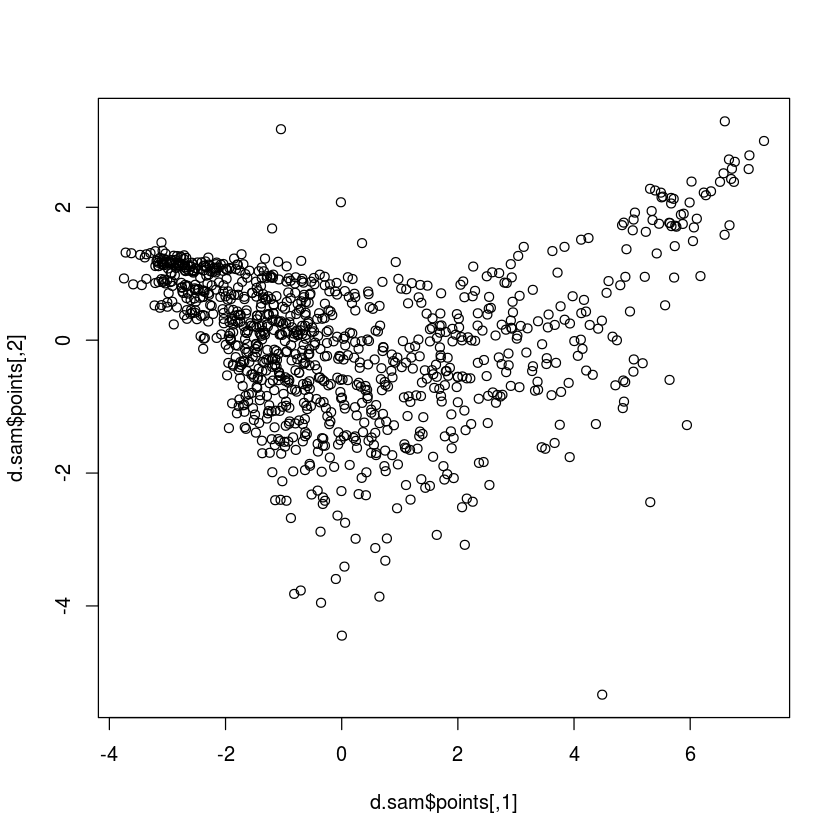

In [7]:
d.u = unique(psample.sc)
d.matr = dist(d.u)
d.sam = sammon(d.matr)
plot(d.sam$points)

Видим, что проекция выборки точек на плоскость занимает (грубо) 10 условных единиц, а по высоте около 6. Оставим прежнее соотношение 4x7.

Построим сеть:

In [5]:
row = 4
col = 7

seed = 777      # Для того, чтобы можно было воспроизвести результаты, 
set.seed(seed)  # установим начальное значение для генератора случайных чисел

grd = somgrid(col, row, "hexagonal")

d.som = som(data = as.matrix(pdata.sc), 
            grid = grd, 
            rlen=5000
)

summary(d.som)

som map of size 7x4 with a hexagonal topology.
Training data included; dimension is 23209 by 8
Mean distance to the closest unit in the map: 0.926463


#### Строим графики полученных карт.

(если смотреть графики в отдельном окне, то они выглядят крупнее)

In [6]:
png("img/som_filtered_dhi_hfp.png", width=2048, height=1024, units="px")
 plot(d.som)
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_filtered_dhi_hfp.png">

Построим график числа точек, которые лежат в районе узлов сетки:

In [10]:
png("img/som_count_filtered_dhi_hfp.png", width=2048, height=1024, units="px")
  plot(d.som, type='count')
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_count_filtered_dhi_hfp.png">

Построим график среднего расстояния от точек, связанных с узлом сети, до этого узла:

In [11]:
png("img/som_distance_filtered_dhi_hfp.png", width=2048, height=1024, units="px")
  plot(d.som, type='quality')
dev.off()

png 
  2

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_distance_filtered_dhi_hfp.png">

#### Беглый обзор карты Кохонена

#### Экспорт результатов для представления на карте

Экспортируем результаты и посмотрим их на карте. Т.е. для каждой точки из исходной таблицы мы пропишем номер класса, в который она попала, и сохраним в новый файл.

Вспомогательные функции, переводят номер класса в номер строки и столбца:

In [12]:
rnum = function(i, row, col){
    1 + (i-1) %/% col
}
cnum = function(i, row, col){
    x = (i %% col)
    if (x == 0)
        col
    else
        x
}
        
row.nums = sapply(d.som$unit.classif, rnum, row=4, col=8)
col.nums = sapply(d.som$unit.classif, cnum, row=4, col=8)

Экспорт результатов:

In [13]:
result = points

result$class = d.som$unit.classif
result$row = row.nums
result$col = col.nums

write.csv('classification_filtered_dhi_hfp.csv', x=result)

### Анализ полученных классов в географическом пространстве

Результат классификации был экспортирован сюда: http://kolesov.nextgis.com/resource/92/display. Подпись к точкам - это номер класса, который был ей присвоен. 

Для удобства работы, чтобы не листать блокнот, скопирую сюда полученную карту Кохонена. И запишу номера классов узлов карты (номера полученных классов). Нумерация классов идет слева направо сверху вниз, т.е. левый нижний угол карты Кохонена имеет номер 1, а правый верхний - 28.

```
 22    23    24    25    26    27    28
    15    16    17    18    19    20    21
 8      9    10    11    12    13    14
    1      2     3    4      5     6     7
```

<img src="https://176.9.38.120/cruncher/files/DHI/img/som_filtered_dhi_hfp.png">

### Предварительный вывод

Самый непонятный класс - это который отличается высокой куммулятивной продуктивностью, малой сезонностью и малым биоразнообразием (при низкой антропогенной нагрузке). Наиболее ярковыраженный представитель - это класс номер 25. Посмотрим, где он расположен на карте: http://kolesov.nextgis.com/resource/92/display?base=osm-mapnik&lon=130.2539&lat=-24.8466&angle=0&zoom=4&styles=93. Оказывается, что основная часть точек расположена в восточной части Индонезии, Новой Зеландии, южной части Австралии с Тасманией, западное побережье США (севернее Сан-Франциско), Чили. Самая засада в том, данные по антропогенной нагрузке было решено подключить, глядя на эти территории. Оказывается здесь она не оказывает значительного влияния (если сравнивать с другими территориями). 

Возможно, нужно смотреть, какое именно влияние? Есть более важный фактор по сравнению с антропогенным?